Alunos:
Guilherme Malgarizi Vasquez, Henrique Zapella Rocha, Pedro Mezacasa Muller

In [1]:
%pip install pandas seaborn matplotlib scikit-learn torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn, optim
from collections import Counter
from torchvision import transforms
from torchvision.io import decode_image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset, DataLoader

In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [4]:
transform = transforms.Compose([transforms.Lambda(lambda x: x.float() / 255.0), transforms.Resize((64, 64)), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset = CustomImageDataset('data/dive_signs.csv', 'data/imgs/', transform=transform)

In [5]:
labels_map = {
    0: "down",
    1: "ok",
    2: "up"
}

In [6]:
dataset_idx = list(range(len(dataset)))
dataset_idx_labels = [dataset.img_labels.iloc[i, 1] for i in dataset_idx]

In [7]:
train_idx, test_idx = train_test_split(dataset_idx, train_size=0.8, test_size=0.2, random_state=42, stratify=dataset_idx_labels)

train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)

In [8]:
img, lbl = dataset[0]
print(img.size())

print(f"training set: {len(train_set)}")
print(f"test set: {len(test_set)}")

torch.Size([3, 64, 64])
training set: 240
test set: 60


In [9]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

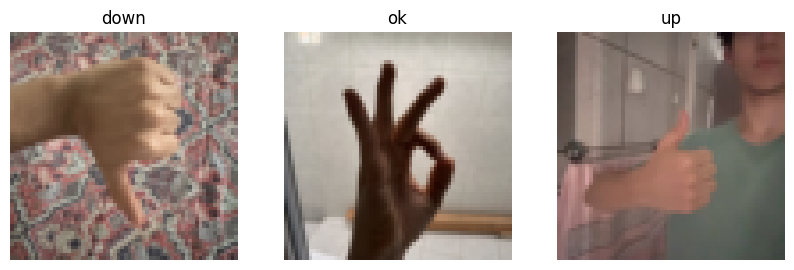

In [10]:
fig, axes = plt.subplots(1, len(labels_map), figsize=(10, 3))
for i in range(len(labels_map)):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    denormalized_image = image / 2 + 0.5
    axes[i].imshow(denormalized_image)
    axes[i].set_title(labels_map[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()

In [11]:
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 24, kernel_size=5) # (24, 60, 60)
        self.pool  = nn.MaxPool2d(2, 2) # (24, 30, 30)
        self.conv2 = nn.Conv2d(24, 48, kernel_size=5) # (48, 26, 26) -> (48, 13, 13) -> Flatten (48 * 13 * 13)
        self.fc1   = nn.Linear(48 * 13 * 13, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
model = ConvNeuralNet().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 5/30 | Loss: 0.6377 | Val Acc: 66.67%
Epoch 10/30 | Loss: 0.1979 | Val Acc: 70.00%
Epoch 15/30 | Loss: 0.0469 | Val Acc: 68.33%
Epoch 20/30 | Loss: 0.0031 | Val Acc: 71.67%
Epoch 25/30 | Loss: 0.0008 | Val Acc: 71.67%
Epoch 30/30 | Loss: 0.0005 | Val Acc: 71.67%

Final Training Loss: 0.0005
Final Validation Accuracy: 71.67%


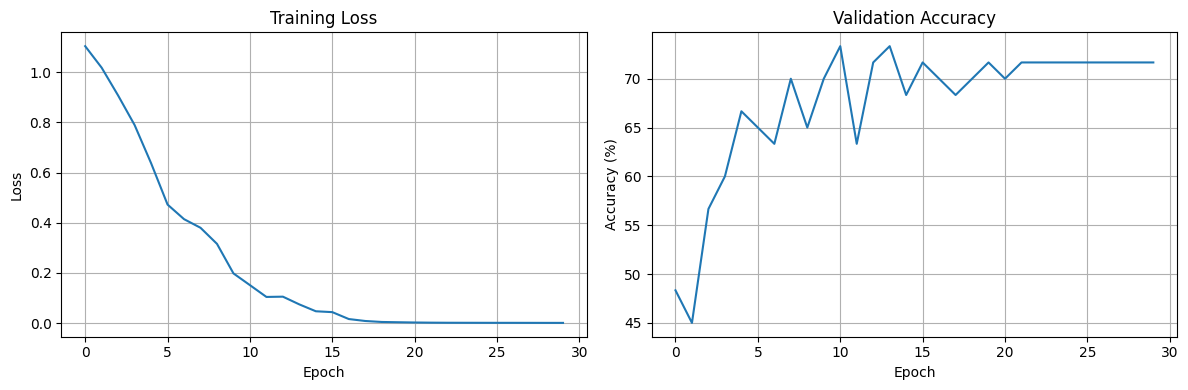

In [ ]:
epochs = 30
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)


    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}\tLoss: {avg_loss:.4f}\tVal Acc: {val_acc:.2f}%")

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

# Plot training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), f"trained_model-2.pth")

In [26]:
model = ConvNeuralNet().to(device)
model.load_state_dict(torch.load("trained_model.pth"))

<All keys matched successfully>

Prediction distribution:	Counter({np.int64(1): 21, np.int64(0): 20, np.int64(2): 19})
Actual label distribution:	Counter({np.int64(0): 20, np.int64(2): 20, np.int64(1): 20})


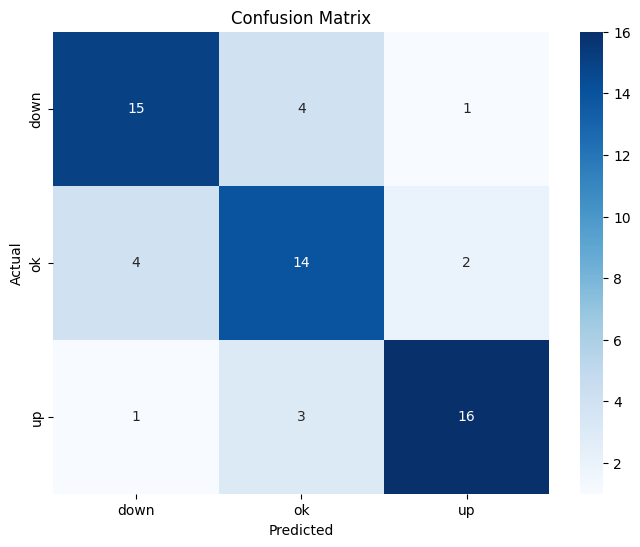


Per-class accuracy:
down:	15/20	= 75.00%
ok:	14/20	= 70.00%
up:	16/20	= 80.00%


In [27]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Prediction distribution:\t{Counter(all_predictions)}")
print(f"Actual label distribution:\t{Counter(all_labels)}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['down', 'ok', 'up'],
            yticklabels=['down', 'ok', 'up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nPer-class accuracy:")
for i, label_name in enumerate(['down', 'ok', 'up']):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    print(f"{label_name}:\t{class_correct}/{class_total}\t= {100*class_correct/class_total:.2f}%")

In [28]:
def load_image(img_path):
    image = decode_image(img_path)
    image = transform(image)
    image = image.unsqueeze(0)
    return image

In [29]:
eval_df = pd.read_csv('data/eval/eval_labels.csv')

correct_predictions = 0
total_predictions = 0

model.eval()
with torch.no_grad():
    for idx, row in eval_df.iterrows():
        img_path = os.path.join("data/eval", row.iloc[0])
        image = load_image(img_path).to(device)
        
        output = model(image)
        _, predicted = torch.max(output, 1)
        
        actual_label = labels_map[row.iloc[1]]
        predicted_label = labels_map[predicted.item()]

        if actual_label == predicted_label:
            correct_predictions += 1
        total_predictions += 1

        print(f"Image: {row.iloc[0]}\tLabel: {actual_label}\tPrediction: {predicted_label}")


accuracy = 100 * correct_predictions / total_predictions
print(f"\nEvaluation Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_predictions})")

Image: IMG_2937.jpeg	Label: up	Prediction: up
Image: IMG_2938.jpeg	Label: down	Prediction: down
Image: IMG_2939.jpeg	Label: ok	Prediction: ok
Image: IMG_2940.jpeg	Label: down	Prediction: ok
Image: IMG_2941.jpeg	Label: down	Prediction: down
Image: IMG_2942.jpeg	Label: down	Prediction: down
Image: IMG_2943.jpeg	Label: down	Prediction: down
Image: IMG_2944.jpeg	Label: ok	Prediction: ok
Image: IMG_2945.jpeg	Label: ok	Prediction: ok
Image: IMG_2946.jpeg	Label: ok	Prediction: ok
Image: IMG_2947.jpeg	Label: ok	Prediction: ok
Image: IMG_2948.jpeg	Label: up	Prediction: ok
Image: IMG_2949.jpeg	Label: up	Prediction: ok
Image: IMG_2950.jpeg	Label: up	Prediction: down
Image: IMG_2951.jpeg	Label: up	Prediction: up

Evaluation Accuracy: 73.33% (11/15)
